In [47]:
from bs4 import BeautifulSoup
import pandas as pd
import requests

In [48]:
src=requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(src, 'html.parser')
jnk=soup.prettify()

In [49]:
table_post=soup.find('table',class_='wikitable sortable')
table_rows=table_post.find_all('tr')
#each tr tag within the table of postal codes have been retrieved as a list, from here continue to ,make the dataframe later using the rules mentioned in the coursera page

In [50]:
df_toronto = pd.DataFrame(columns=['Postal Code','Borough','Neighborhood'])


In [51]:
postal_codes=[]
for i in table_rows[1:]:
    postal_codes.append(i.td.text)
postal_codes=list(set(postal_codes)) #getting the unique postal codes   

In [52]:
dic_post={}
for i in postal_codes:
    list_places=['']
    dic_post[i]=list_places


In [53]:
for i in table_rows[1:]:
    row=i.find_all('td')
    temp=dic_post[row[0].text]
    temp[0]=row[1].text
    emp_list=[]
    temp.append(emp_list)
    temp=temp[0:2]
    dic_post[row[0].text]=temp
    


In [54]:
for i in table_rows[1:]:
    row=i.find_all('td')
    new_list=dic_post[row[0].text]
    temp=new_list[1]
    temp.append(row[2].text.strip('\n'))
    new_list[1]=temp
    dic_post[row[0].text]=new_list


In [55]:
df_toronto = pd.DataFrame(columns=['Postal Code','Borough','Neighborhood'])
#Generating the pd dataframe
#Also assigning Borough name as the neighborhood names to the places with neighborhood name given as not assigned
for i in dic_post:
    tmp_list=dic_post[i]
    neighb_list=tmp_list[1]
    neighb_list = [w.replace('Not assigned', tmp_list[0]) for w in neighb_list]  #Assigning the borough name as the neighborhood name for neighborhoods with not assigned
    df_toronto=df_toronto.append({'Postal Code' : i , 'Borough' : tmp_list[0],'Neighborhood':neighb_list} , ignore_index=True)
df_toronto.head()

,Postal Code,Borough,Neighborhood
0,M5G,Downtown Toronto,[Central Bay Street]
1,M6Z,Not assigned,[Not assigned]
2,M9P,Etobicoke,[Westmount]
3,M6C,York,[Humewood-Cedarvale]
4,M5J,Downtown Toronto,"[Harbourfront East, Toronto Islands, Union Sta..."


In [56]:
df_toronto=df_toronto[df_toronto['Borough']!='Not assigned'] #removing all the postal codes that are not assigned
df_toronto.head()

,Postal Code,Borough,Neighborhood
0,M5G,Downtown Toronto,[Central Bay Street]
2,M9P,Etobicoke,[Westmount]
3,M6C,York,[Humewood-Cedarvale]
4,M5J,Downtown Toronto,"[Harbourfront East, Toronto Islands, Union Sta..."
5,M4P,Central Toronto,[Davisville North]


In [57]:
neighb_tmp=df_toronto['Neighborhood'] #converting the neighborhood column from a list to neighborhood names split by ,
i=0
fin_neighb_tmp=[]
for i in neighb_tmp:
    tmp=i
    fin_neighb_tmp.append(','.join(tmp))
df_toronto['Neighborhood']=fin_neighb_tmp

In [58]:
#final dataframe after wrangling
df_toronto.head()

,Postal Code,Borough,Neighborhood
0,M5G,Downtown Toronto,Central Bay Street
2,M9P,Etobicoke,Westmount
3,M6C,York,Humewood-Cedarvale
4,M5J,Downtown Toronto,"Harbourfront East,Toronto Islands,Union Station"
5,M4P,Central Toronto,Davisville North


In [59]:
#Now let's move onto getting the latitudes and longitudes of each borough in Toronto
df_lat=pd.read_csv('https://cocl.us/Geospatial_data')
df_lat.head()
df_lat_ind=df_lat.set_index('Postal Code')


In [60]:
df_toronto['Latitude']=0 #Creating new columns latitude and longitude and setting the default value to be one
df_toronto['Longitude']=0
list_lat=[]
list_lon=[]
for index, row in df_toronto.iterrows():
    list_lat.append(df_lat_ind.loc[row['Postal Code']][0])   #Iterating through the rows to get the corresponding Latitude and Longitude values for the postal codes available and storing them in a list
    list_lon.append(df_lat_ind.loc[row['Postal Code']][1])
df_toronto['Latitude']=list_lat
df_toronto['Longitude']=list_lon  #assigning the lists to the columns

In [61]:
df_toronto.head(10) #Given here is the final Dataset that is to be used for segmentation

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
2,M9P,Etobicoke,Westmount,43.696319,-79.532242
3,M6C,York,Humewood-Cedarvale,43.693781,-79.428191
4,M5J,Downtown Toronto,"Harbourfront East,Toronto Islands,Union Station",43.640816,-79.381752
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197
6,M4B,East York,"Woodbine Gardens,Parkview Hill",43.706397,-79.309937
8,M9L,North York,Humber Summit,43.756303,-79.565963
9,M1T,Scarborough,"Clarks Corners,Sullivan,Tam O'Shanter",43.781638,-79.304302
12,M9N,York,Weston,43.706876,-79.518188
13,M3L,North York,Downsview West,43.739015,-79.506944


### Now Let's beging with our analysis. Our analysis would be to segment the neighborhoods in the boroughs,whose borough names contain the word 'Toronto' in it.So first, let's make the required transforms in the dataset

In [62]:
df_toronto['Borough'].value_counts()
#from this we can tell that four boroughs contabn the word toronto

North York          24
Downtown Toronto    18
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
East Toronto         5
East York            5
York                 5
Mississauga          1
Queen's Park         1
Name: Borough, dtype: int64

In [63]:
df_toronto=df_toronto[(df_toronto['Borough']=='Downtown Toronto')|( df_toronto['Borough']=='Central Toronto')|(df_toronto['Borough']=='West Toronto')|(df_toronto['Borough']=='East Toronto')]
df_toronto.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
4,M5J,Downtown Toronto,"Harbourfront East,Toronto Islands,Union Station",43.640816,-79.381752
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197
14,M5P,Central Toronto,"Forest Hill North,Forest Hill West",43.696948,-79.411307
15,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572


In [64]:
tmp_list=[]
emp_list=[]
tmp_list=list(df_toronto['Neighborhood'])
for i in tmp_list:
    emp_list.append(i.split(",")[0])
df_toronto['Neighborhood']=emp_list


In [65]:
df_toronto.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
4,M5J,Downtown Toronto,Harbourfront East,43.640816,-79.381752
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197
14,M5P,Central Toronto,Forest Hill North,43.696948,-79.411307
15,M4L,East Toronto,The Beaches West,43.668999,-79.315572


### Given that we have done the transform to the dataset, let's visualise what we've gotten 

In [66]:
import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

In [67]:
address = 'Toronto,Canada'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto are 43.653963, -79.387207.


In [68]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_toronto['Latitude'],df_toronto['Longitude'],df_toronto['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [69]:
#defining foursquare credentials
CLIENT_ID = 'QJVQPJKNZSPO2P0TYHSOC4KCXO5MZSA2ETMSABYTFNIR2OG3' # your Foursquare ID
CLIENT_SECRET = 'L0KKAUXMMVCPH3MT4HAICR1IP10T5XIANDL0025ZX2RVFYPT' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QJVQPJKNZSPO2P0TYHSOC4KCXO5MZSA2ETMSABYTFNIR2OG3
CLIENT_SECRET:L0KKAUXMMVCPH3MT4HAICR1IP10T5XIANDL0025ZX2RVFYPT


In [70]:
LIMIT=100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Now let's get the nearby venues of all the neighborhoods by making API calls to foursquare and store the details about all the venus of all the negohborhoods in a dataframe

In [71]:
# type your answer here

toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )

toronto_venues.head()

Central Bay Street
Harbourfront East
Davisville North
Forest Hill North
The Beaches West
Stn A PO Boxes 25 The Esplanade
Parkdale
Commerce Court
Rosedale
Ryerson
The Beaches
Adelaide
Business Reply Mail Processing Centre 969 Eastern
Davisville
Christie
Lawrence Park
St. James Town
Harbord
Runnymede
CN Tower
Brockton
Little Portugal
Roselawn
First Canadian Place
Chinatown
High Park
Moore Park
Berczy Park
Cabbagetown
Studio District
The Danforth West
Harbourfront
North Toronto West
Deer Park
Design Exchange
Dovercourt Village
Church and Wellesley
The Annex


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Central Bay Street,43.657952,-79.387383,Jimmy's Coffee,43.658421,-79.385613,Coffee Shop
1,Central Bay Street,43.657952,-79.387383,Tim Hortons,43.658570,-79.385123,Coffee Shop
2,Central Bay Street,43.657952,-79.387383,Hailed Coffee,43.658833,-79.383684,Coffee Shop
3,Central Bay Street,43.657952,-79.387383,Mercatto,43.660391,-79.387664,Italian Restaurant
4,Central Bay Street,43.657952,-79.387383,The Queen and Beaver Public House,43.657472,-79.383524,Gastropub


### Now, i am going to organize the data for the number of stores in each category for each neighborhood by performing one-hot encoding

In [72]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] =toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [73]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint
0,Adelaide,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,...,0.00,0.000000,0.00000,0.00,0.010000,0.000000,0.000000,0.000000,0.010000,0.000000
1,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.00000,0.00,0.017857,0.000000,0.000000,0.000000,0.000000,0.000000
2,Brockton,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Business Reply Mail Processing Centre 969 Eastern,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,CN Tower,0.000000,0.000000,0.058824,0.058824,0.058824,0.117647,0.176471,0.117647,0.000000,...,0.00,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Cabbagetown,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020833,...,0.00,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Central Bay Street,0.011765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011765,...,0.00,0.000000,0.00000,0.00,0.011765,0.000000,0.011765,0.000000,0.011765,0.000000
7,Chinatown,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.01,0.000000,0.00000,0.00,0.060000,0.000000,0.000000,0.050000,0.010000,0.000000
8,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Church and Wellesley,0.011905,0.011905,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011905,...,0.00,0.000000,0.00000,0.00,0.000000,0.011905,0.000000,0.011905,0.000000,0.011905


### Now let's take the top 10 areas in each neighborhood

In [74]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [85]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Coffee Shop,Café,Thai Restaurant,Bar,Steakhouse,Breakfast Spot,Restaurant,Hotel,Gym,Asian Restaurant
1,Berczy Park,Coffee Shop,Cocktail Bar,Farmers Market,Beer Bar,Bakery,Steakhouse,Seafood Restaurant,Cheese Shop,Café,Fish Market
2,Brockton,Coffee Shop,Café,Breakfast Spot,Gym,Intersection,Performing Arts Venue,Pet Store,Grocery Store,Climbing Gym,Caribbean Restaurant
3,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Smoke Shop,Garden Center,Restaurant,Recording Studio,Skate Park,Auto Workshop,Burrito Place,Fast Food Restaurant,Garden
4,CN Tower,Airport Service,Airport Terminal,Airport Lounge,Harbor / Marina,Coffee Shop,Plane,Boat or Ferry,Boutique,Sculpture Garden,Airport Gate


### Now,since we have our dataset all ready, let's move onto segmentation. Segmentation can be done through clustering the neighborhoods with their latitude and longitude values and the categories for the top 10 most common venues. Now, the algorithm that is to be used here is the k-means clustering algorithm

In [76]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)


0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
Name: clusters, dtype: int32
0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    0
18    1
19    1
20    1
21    1
22    0
23    1
24    0
25    1
26    1
27    0
28    1
29    1
30    1
31    1
32    1
33    1
34    1
35    1
36    1
37    1
Name: clusters, dtype: int32
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    1
18    0
19    0
20    0
21    0
22    1
23    0
24    1
25    0
26    0
27    1
28    2
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
Name: clusters, dtype: int32
0

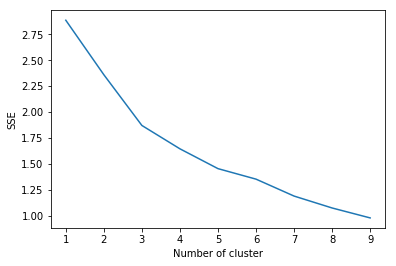

In [79]:
#here we are using the elbow method to determine the optimal number of clusters
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=100).fit(toronto_grouped_clustering)
    toronto_grouped_clustering["clusters"] = kmeans.labels_
    print(toronto_grouped_clustering["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

### Using the elbow curve method, we can see that the optimal amount of clusters will be 5 so let us take k to be 5 and retrain the model

In [81]:
kmeans_final= KMeans(n_clusters=5, max_iter=100).fit(toronto_grouped_clustering)


In [87]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans_final.labels_)
toronto_merged = df_toronto
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,1,Coffee Shop,Italian Restaurant,Café,Ice Cream Shop,Burger Joint,Sandwich Place,Chinese Restaurant,Bubble Tea Shop,Spa,Bar
4,M5J,Downtown Toronto,Harbourfront East,43.640816,-79.381752,1,Coffee Shop,Hotel,Aquarium,Café,Italian Restaurant,Pizza Place,Brewery,Sporting Goods Shop,Scenic Lookout,Bakery
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197,4,Gym,Breakfast Spot,Food & Drink Shop,Hotel,Clothing Store,Sandwich Place,Park,Ethiopian Restaurant,Electronics Store,Discount Store
14,M5P,Central Toronto,Forest Hill North,43.696948,-79.411307,0,Park,Trail,Jewelry Store,Sushi Restaurant,Wings Joint,Diner,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
15,M4L,East Toronto,The Beaches West,43.668999,-79.315572,4,Park,Sandwich Place,Ice Cream Shop,Pizza Place,Movie Theater,Pub,Burrito Place,Burger Joint,Brewery,Liquor Store


### Now we can see that the clustering process has been done and the corresponding labels have been tagged

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Central Toronto,0,Park,Trail,Jewelry Store,Sushi Restaurant,Wings Joint,Diner,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
67,Downtown Toronto,0,Airport Service,Airport Terminal,Airport Lounge,Harbor / Marina,Coffee Shop,Plane,Boat or Ferry,Boutique,Sculpture Garden,Airport Gate
